In [1]:
import  pandas as pd
import numpy as np
import pandas_ta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('Fraud.csv')
df.head()
# shape (1048575, 14)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1048575.0
mean,2.696617e+01,1.586670e+05,8.740095e+05,8.938089e+05,9.781600e+05,1.114198e+06,1.089097e-03,0.0
std,1.562325e+01,2.649409e+05,2.971751e+06,3.008271e+06,2.296780e+06,2.416593e+06,3.298351e-02,0.0
min,1.000000e+00,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,1.500000e+01,1.214907e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
50%,2.000000e+01,7.634333e+04,1.600200e+04,0.000000e+00,1.263772e+05,2.182604e+05,0.000000e+00,0.0
75%,3.900000e+01,2.137619e+05,1.366420e+05,1.746000e+05,9.159235e+05,1.149808e+06,0.000000e+00,0.0
max,9.500000e+01,1.000000e+07,3.890000e+07,3.890000e+07,4.210000e+07,4.220000e+07,1.000000e+00,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB


In [5]:
## checking NA value

df.isnull().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [6]:

#checking duplicate
df.duplicated().sum()

0

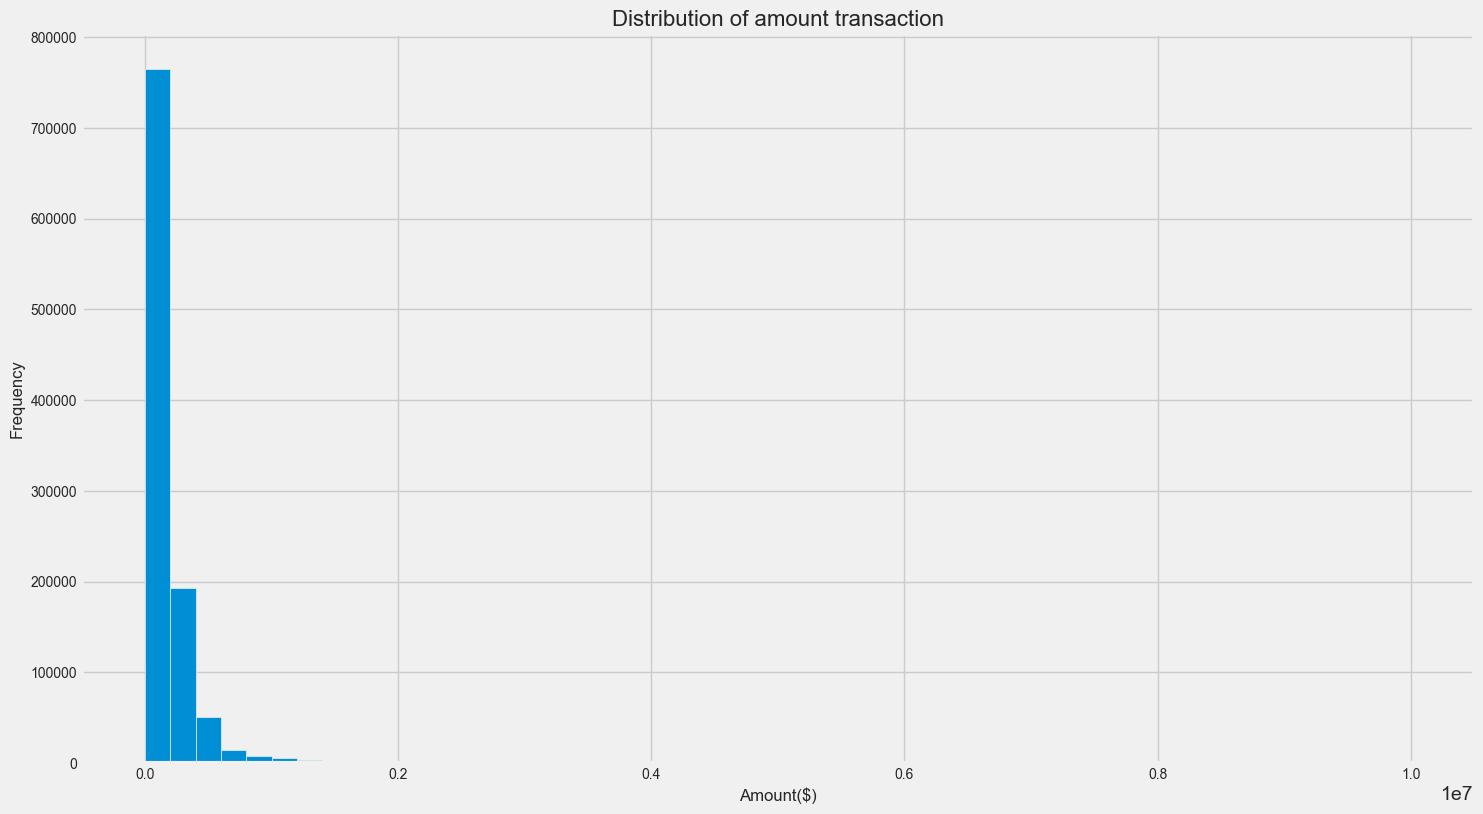

In [7]:
plt.figure(figsize= (16, 9))
plt.hist(df['amount'], bins = 50)
# Set labels and title
plt.xlabel('Amount($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of amount transaction', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show;

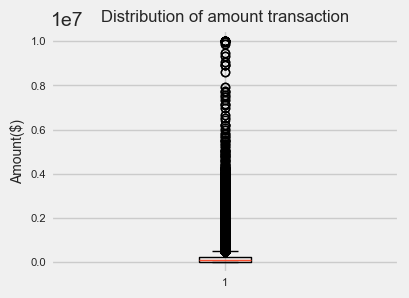

In [8]:
plt.figure(figsize = (4,3))
plt.boxplot(df['amount'])
# Set labels and title
plt.ylabel('Amount($)', fontsize=10)

plt.title('Distribution of amount transaction', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show;

/var/folders/71/ygrm6v2d3zq5y8nmqn34lsbw0000gn/T/ipykernel_26706/3778239136.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


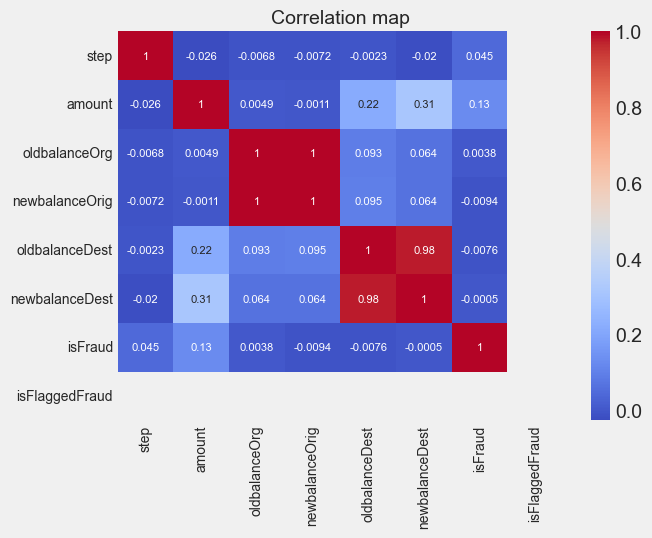

In [9]:
correlation_matrix = df.corr()

# Plot the correlation map using a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={'size': 8})
# Set the title
plt.title('Correlation map', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show;

# Display the plot
plt.show()

In [10]:
# nameOrig and nameDest is id for customer, for the first letter just 2 type C or M -> create new column for those features
df['fist_nameDest'] = df['nameDest'].str[0]
df['fist_nameOrig'] = df['nameOrig'].str[0]


In [11]:
# Creates a new column which has 1 if the transaction amount is greater than the threshold (0.75)
# else it will be 0
df['surge']=[1 if n>450000 else 0 for n in df['amount']]

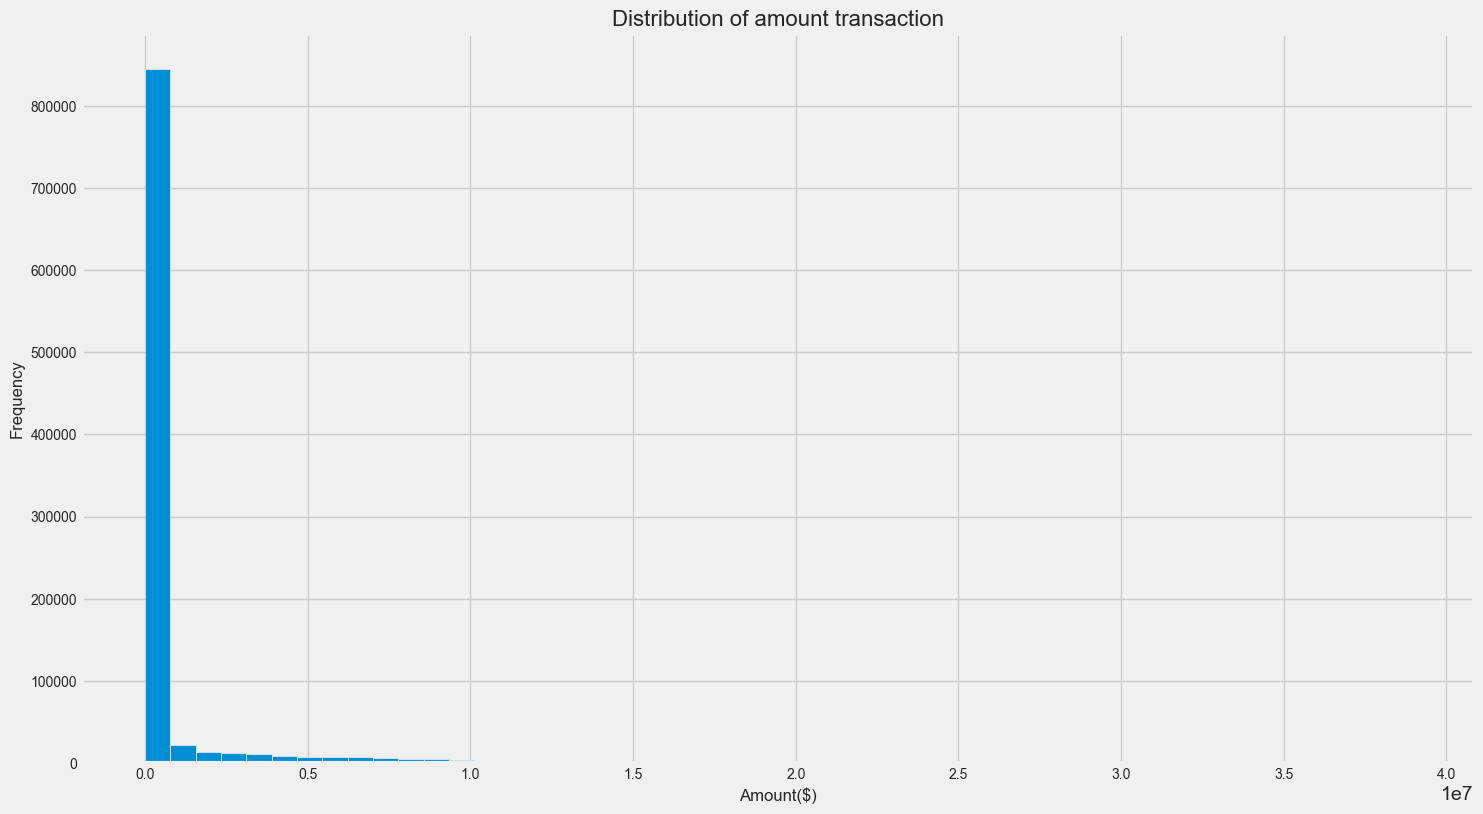

In [12]:
plt.figure(figsize= (16, 9))
plt.hist(df['newbalanceOrig'].loc[df['surge']==0], bins = 50)
# Set labels and title
plt.xlabel('Amount($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of amount transaction', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show;

# Pre-processing data

In [13]:
# make a copy for data set
df_1 = df.copy()

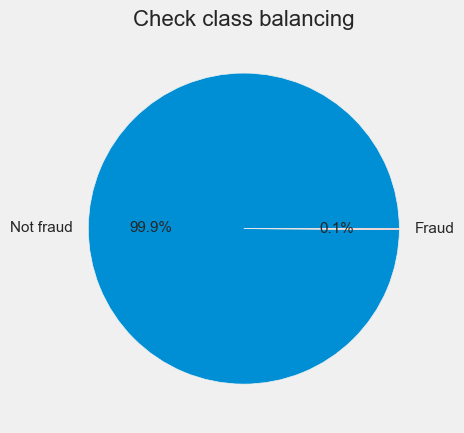

In [14]:
size = df_1['isFraud'].value_counts()
# chart
plt.pie(size, labels = ['Not fraud', 'Fraud'], autopct = '%1.1f%%',textprops={'fontsize': 11})

plt.title('Check class balancing', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show;

In [15]:
# Encoding by using LabelEncoder

label_encoder = LabelEncoder()
df_1['fist_nameDest'] = label_encoder.fit_transform(df_1['fist_nameDest'])
df_1['fist_nameOrig'] = label_encoder.fit_transform(df_1['fist_nameOrig'])


# One-hot encoding for date columns
df_1 = pd.get_dummies(df_1, columns=['type'], prefix=['type'])


In [16]:
df_1.drop(columns = ['nameOrig', 'nameDest', 'isFlaggedFraud'], inplace = True)

In [17]:
df_sample = df_1.head(10)
df_sample.loc[df_sample['isFraud'] == 0, 'isFraud'] = 'No Fraud'
df_sample.loc[df_sample['isFraud'] == 1, 'isFraud'] = 'Fraud'
df_sample

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,fist_nameDest,fist_nameOrig,surge,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.00,160296.36,0.0,0.00,No Fraud,1,0,0,0,0,0,1,0
1,1,1864.28,21249.00,19384.72,0.0,0.00,No Fraud,1,0,0,0,0,0,1,0
2,1,181.00,181.00,0.00,0.0,0.00,Fraud,0,0,0,0,0,0,0,1
3,1,181.00,181.00,0.00,21182.0,0.00,Fraud,0,0,0,0,1,0,0,0
4,1,11668.14,41554.00,29885.86,0.0,0.00,No Fraud,1,0,0,0,0,0,1,0
5,1,7817.71,53860.00,46042.29,0.0,0.00,No Fraud,1,0,0,0,0,0,1,0
6,1,7107.77,183195.00,176087.23,0.0,0.00,No Fraud,1,0,0,0,0,0,1,0
7,1,7861.64,176087.23,168225.59,0.0,0.00,No Fraud,1,0,0,0,0,0,1,0
8,1,4024.36,2671.00,0.00,0.0,0.00,No Fraud,1,0,0,0,0,0,1,0
9,1,5337.77,41720.00,36382.23,41898.0,40348.79,No Fraud,0,0,0,0,0,1,0,0


In [18]:
df_sample.to_csv("transformed_data_sample.csv", index = False)

### Handle imbalancing class

In [19]:
df_1.head(3)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,fist_nameDest,fist_nameOrig,surge,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,1,0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,1,0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,0,0,0,1


In [20]:
X = df_1.drop('isFraud', axis=1)
y = df_1['isFraud']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Concatenate 'X_train' and 'y_train' into a single DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data['isFraud'] == 0] 
minority_class = train_data[train_data['isFraud'] == 1] 

# Calculate the desired sizes for majority and minority classes based on the desired ratio
desired_majority_size = int(len(minority_class))
desired_minority_size = len(minority_class)

# Oversample the minority class
oversampled_minority = minority_class.sample(n=desired_minority_size, replace=True, random_state=42)

# Undersample the majority class
undersampled_majority = majority_class.sample(n=desired_majority_size, random_state=42)

# Combine the oversampled minority class and undersampled majority class
balanced_data = pd.concat([oversampled_minority, undersampled_majority])

# Shuffle the balanced data
balanced_data = balanced_data.sample(frac=1, random_state=42)

# Separate the features and target variable
X_balanced = balanced_data.drop('isFraud', axis=1)
y_balanced = balanced_data['isFraud']

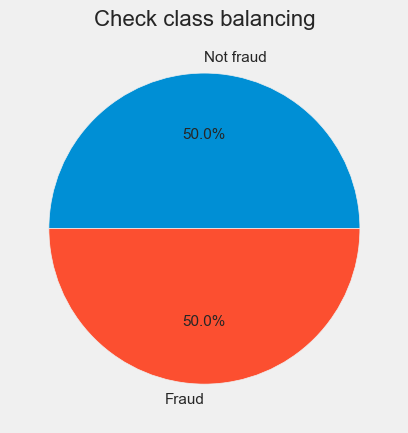

In [21]:
size = y_balanced.value_counts()
# chart
plt.pie(size, labels = ['Not fraud', 'Fraud'], autopct = '%1.1f%%',textprops={'fontsize': 11})

plt.title('Check class balancing', fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show;

In [22]:
# Create a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'max_depth': [None ,4, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [1 ,4, 5, 10, 15, 20, 25, 30],
    'max_leaf_nodes': [None,7,9, 10, 20, 30, 40],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_balanced, y_balanced)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Access the best trained model
best_model = grid_search.best_estimator_


Best Hyperparameters: {'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_split': 5}


              precision    recall  f1-score   support

           0       1.00      0.97      0.98    418985
           1       0.03      0.96      0.06       445

    accuracy                           0.97    419430
   macro avg       0.52      0.96      0.52    419430
weighted avg       1.00      0.97      0.98    419430



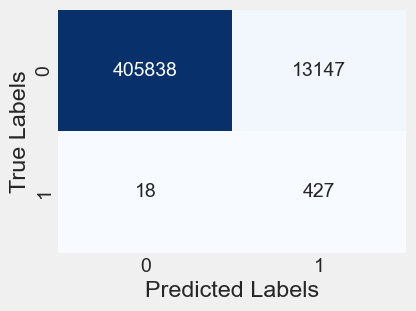

In [23]:

# Create a decision tree classifier
clf = DecisionTreeClassifier(max_depth = 10, max_leaf_nodes= None, min_samples_split= 1, random_state=42)

# Fit the classifier to the training data
clf.fit(X_balanced, y_balanced)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show();


In [24]:
# TO-DO: next steps. Do feature selection imporve model

from sklearn.feature_selection import SelectKBest, f_regression
k=10
# Select the top-k features using SelectKBest and f_regression
selector = SelectKBest(score_func=f_regression, k=k)
selector.fit(X_balanced, y_balanced)

# Select the top-k features
top_k_features = X.columns[selector.get_support()]
top_k_features

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'fist_nameDest',
       'surge', 'type_CASH_IN', 'type_CASH_OUT', 'type_PAYMENT',
       'type_TRANSFER'],
      dtype='object')

In [25]:
result = pd.DataFrame({'isFraud': y_test, 'Pred': y_pred}).reset_index(drop = True)
result.head(3)

,isFraud,Pred
0,0,0
1,0,0
2,0,0


In [26]:
result.to_csv('result_predict_fraud.csv', index = True)